In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import product
from collections import Counter, defaultdict
import plotly.graph_objects as go
import numpy as np
import powerlaw
from seaborn import kdeplot
import seaborn as sns

In [2]:
R = pd.read_pickle("edgelist_reindexed_2.pkl")
mask = (R._start_type == "Officers") & (R._end_type == "Entity")
VC = R[mask].link.value_counts()
beneficiary = np.array([0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,
                       0,0,0,0,0,0,0,0], dtype = bool)

print( "Beneficiary classes: ", list(VC.iloc[:len(beneficiary)][beneficiary].index ))
print("--------------")
print( "Nominee class: ",       list(VC.iloc[:len(beneficiary)][~beneficiary].index ))
ben_class = list(VC.iloc[:len(beneficiary)][beneficiary].index)
rep_class = list(VC.iloc[:len(beneficiary)][~beneficiary].index)
mask = (R._start_type == "Officers") & (R._end_type == "Entity") & (R.link.isin(rep_class))
R_OG = R.copy()
R = R[~mask]

Beneficiary classes:  ['beneficiary of', 'Ultimate Beneficial Owner', 'owner of', 'Beneficial Owner', 'beneficial owner of', 'ultimate beneficial owner of', 'partner of', 'trust settlor of']
--------------
Nominee class:  ['shareholder of', 'director of', 'secretary of', 'judicial representative of', 'legal representative of', 'records & registers of', 'auditor of', 'managing director of', 'director', 'vice-president of', 'liquidator of', 'is signatory for', 'president of', 'intermediary of', 'auditor', 'secretary', 'proxy of', 'manager of', 'treasurer of', 'chairman of', 'appleby assigned attorney', 'power of attorney of', 'director / president', 'board-member of', 'director / secretary', 'executive director of', 'trustee of trust of', 'assistant secretary of', 'president', 'connected to', 'authorised person / signatory of', 'chief executive officer of', 'protector of', 'chairman of the board of', 'chief financial officer of', 'power of attorney', 'independent non executive director o

## Get Ratios

In [3]:
def get_ratio(country):
    R1 = R[(R._start_type == "Officers") & (R._start_country == country)]
    R2 = R[(R._end.isin(R1._end)) & (R._start_type == "Intermediaries")]
    OffIntRatio = len( R1._start.unique() ) / len(R2._start.unique())
    return country, OffIntRatio

In [4]:
hit_list = ["RUS", "USA", "CHN", 'HKG']
count2color = {"RUS": "red", "USA":"green", "HKG": "blue", "CHN":"black", 
               "CHE": "purple"}

O2I_Rat = []
for ctry in ["CHN", "USA", "RUS", "HKG"][::-1]:
    O2I_Rat.append(get_ratio(ctry))

O2I_CTRY, O2I_Rat,   = [a[0] for a in O2I_Rat], [a[1] for a in O2I_Rat]

1.393589642059015 1.0 0.01676748248395165
1.3638109260482238 1.0 0.011705424673316095
1.2668389144908545 1.0 0.015669320594238475
1.2528479697672135 1.0 0.017790321071825047


(-0.5, 3.7)

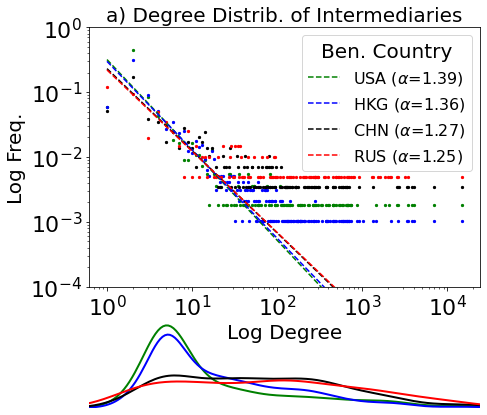

In [7]:
f, axs = plt.subplots(2,1,
                      figsize=(7,7),
#                       sharey=True,
                     gridspec_kw=dict(height_ratios=[3,1]))

for country in ["USA", "HKG", "CHN", "RUS"]:
    R1 = R[(R._start_type == "Officers") & (R._start_country == country)]
    R2 = R[(R._end.isin(R1._end)) & (R._start_type == "Intermediaries")]
    F = R[(R._start_type == "Intermediaries") & (R._end_type == "Entity")]
    F = F[F._start.isin(R2._start)]
    G = nx.Graph()
    G.add_edges_from(F[["_start", "_end"]].values)
    Int_IDS = F._start.unique()
    Int_deg = [G.degree()[n] for n in Int_IDS]

    data = np.array(Int_deg) # data can be list or numpy array
    results = powerlaw.Fit(data, discrete= True, 
                           xmin=1, 
                           fit_method = "KS")
    alpha = (results.power_law.alpha)
    x0 = results.power_law.xmin 

    X = np.linspace(min(data), max(data))
    PL = lambda x: (x0) * (x**(alpha-1) )
    print(alpha, x0, results.sigma)

    results.power_law.plot_pdf(color=count2color[country], linestyle='--', 
                               label = country + r" ($\alpha$={:.2f})".format(alpha), ax = axs[0])
    a,b = np.unique(data, return_counts=True)
    axs[0].scatter(a,b/b.sum(), color = count2color[country], s = 5)
    
    sns.kdeplot(np.log10(Int_deg), linewidth=2, 
                        color = count2color[country], ax = axs[1])

axs[0].set_yscale("log")
axs[1].set_yscale("linear")
legend = axs[0].legend(fontsize=16)
legend.set_title("Ben. Country", {'size':20})

for label in (axs[0].get_xticklabels() + axs[0].get_yticklabels()): 
    label.set_fontsize(22)
    
axs[0].set_ylim(0.0001,1)
axs[0].set_ylabel("Log Freq.", fontsize=20)
axs[0].set_xlabel("Log Degree", fontsize=20)
axs[0].set_title(f"a) Degree Distrib. of Intermediaries", fontsize=20)

axs[1].get_xaxis().set_ticks([])
axs[1].get_yaxis().set_ticks([])
axs[1].axis('off')

axs[1].set_xlim(-0.5,3.7)

# plt.savefig("figures/scatter_kde-2.png")

1.393589642059015 1.0 0.01676748248395165
1.3638109260482238 1.0 0.011705424673316095
1.2668389144908545 1.0 0.015669320594238475
1.2528479697672135 1.0 0.017790321071825047


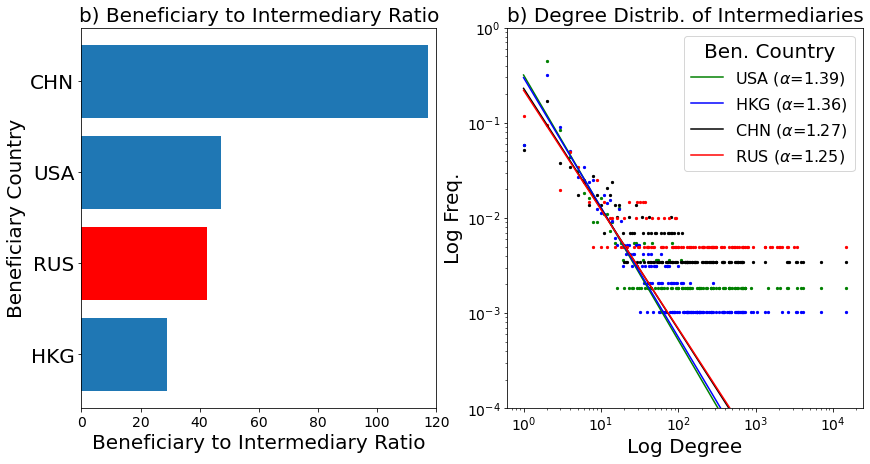

In [97]:
# %%time
ratios = []
plt.figure(figsize=(14,7))

plt.subplot(1,2,1)
plt.barh(np.arange(len(O2I_Rat)), O2I_Rat, )
plt.barh(1, O2I_Rat[1], color = "red")
plt.xticks(fontsize=14)
plt.xlim(0,120)
plt.yticks(np.arange(4), O2I_CTRY, fontsize=20)
plt.xlabel("Beneficiary to Intermediary Ratio", fontsize=20)
plt.ylabel("Beneficiary Country", fontsize=20)
plt.title(f"b) Beneficiary to Intermediary Ratio", fontsize=20)

plt.subplot(1,2,2)

for country in ["USA", "HKG", "CHN", "RUS"]:
    R1 = R[(R._start_type == "Officers") & (R._start_country == country)]
    R2 = R[(R._end.isin(R1._end)) & (R._start_type == "Intermediaries")]
    F = R[(R._start_type == "Intermediaries") & (R._end_type == "Entity")]
    F = F[F._start.isin(R2._start)]
    G = nx.Graph()
    G.add_edges_from(F[["_start", "_end"]].values)
    Int_IDS = F._start.unique()
    Int_deg = [G.degree()[n] for n in Int_IDS]
    data = np.array(Int_deg) # data can be list or numpy array
    results = powerlaw.Fit(data, discrete= True, xmin=1)
    alpha = (results.power_law.alpha)
    x0 = results.power_law.xmin 

    X = np.linspace(min(data), max(data))
    PL = lambda x: (x0) * (x**(alpha-1) )
    print(alpha, x0, results.sigma)

    results.power_law.plot_pdf(color=count2color[country], linestyle='-', 
                               label = country + r" ($\alpha$={:.2f})".format(alpha))
    a,b = np.unique(data, return_counts=True)
    plt.scatter(a,b/b.sum(), color = count2color[country], s = 5)


# plt.yscale("log")
legend = plt.legend(fontsize=16)
legend.set_title("Ben. Country", {'size':20})

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0.0001,1)
plt.ylabel("Log Freq.", fontsize=20)
plt.xlabel("Log Degree", fontsize=20)
plt.title(f"b) Degree Distrib. of Intermediaries", fontsize=20)
plt.savefig("figures/PL_FIT_degree_distrib-3.png")

In [115]:
results.distribution_compare("lognormal", "power_law")

0.13533422407985207

In [145]:
for country in ["USA", "HKG", "CHN", "RUS"]:
    R1 = R[(R._start_type == "Officers") & (R._start_country == country)]
    R2 = R[(R._end.isin(R1._end)) & (R._start_type == "Intermediaries")]
    F = R[(R._start_type == "Intermediaries") & (R._end_type == "Entity")]
    F = F[F._start.isin(R2._start)]
    G = nx.Graph()
    G.add_edges_from(F[["_start", "_end"]].values)
    Int_IDS = F._start.unique()
    Int_deg = [G.degree()[n] for n in Int_IDS]
    data = np.array(Int_deg) # data can be list or numpy array
    results = powerlaw.Fit(data, discrete= True, 
                           xmin=1, 
#                            fit_method = "KS"
                          )
    alpha = (results.power_law.alpha)
    x0 = results.power_law.xmin 
    RR, p = results.distribution_compare('power_law', 'exponential')
    print(RR,p)

1134.0718013952487 9.698002184127623e-17
1359.831993276517 3.3952930822363876e-11
322.56538922577846 3.671800219008174e-06
218.01096524098722 2.3409193263678673e-05


In [149]:
for country in ["USA", "HKG", "CHN", "RUS"]:
    R1 = R[(R._start_type == "Officers") & (R._start_country == country)]
    R2 = R[(R._end.isin(R1._end)) & (R._start_type == "Intermediaries")]
    F = R[(R._start_type == "Intermediaries") & (R._end_type == "Entity")]
    F = F[F._start.isin(R2._start)]
    G = nx.Graph()
    G.add_edges_from(F[["_start", "_end"]].values)
    Int_IDS = F._start.unique()
    Int_deg = [G.degree()[n] for n in Int_IDS]
    data = np.array(Int_deg) # data can be list or numpy array
    results = powerlaw.Fit(data, discrete= True, 
                           xmin=1, 
#                            fit_method = "KS"
                          )
    alpha = (results.power_law.alpha)
    x0 = results.power_law.xmin 
    RR, p = results.distribution_compare('power_law', 'lognormal')
    print(RR,p)

-12.994256887369737 0.011649095444221816
-94.81956801332703 3.254185595936202e-17
-57.290490902339755 3.672561089669088e-12
-33.35150669318129 1.3879975122513505e-07
